# 验证码识别

In [2]:
from tensorflow import keras
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import sklearn
from sklearn.model_selection import train_test_split
import os, sys

# 查看包的版本
for module in keras, tf, np, sklearn:
    print(module.__name__, module.__version__)

keras.api._v2.keras 2.10.0
tensorflow 2.10.0
numpy 1.24.3
sklearn 1.2.2


## 数据预处理
- 使用string模块生成36个字符的列表
- 通过自定义函数加载图像数据集，生成数据集的函数在 create_captcha.ipynb 中 

In [ ]:
import string
characters = string.digits + string.ascii_uppercase # 共有 10 个数字和 26 个英文字母
print(characters)
n_classes = len(characters)

0123456789ABCDEFGHIJKLMNOPQRSTUVWXYZ


In [ ]:
from PIL import Image
def read_data(file_name):
    # 读取图片
    img = Image.open(file_name)
    return np.array(img)


def load_data(file_names):
    data = []
    labels = []
    for file_name in file_names:
        data.append(read_data(file_name))
        target_str = file_name[-8:-4]
        target_list = list(target_str)
        label = []
        for _, char in enumerate(target_list):
            n_class = np.zeros(n_classes)
            n_class[characters.find(char)] = 1
            label.append(n_class)
        labels.append(label)

    return np.array(data), np.array(labels)



In [ ]:
file_names = os.listdir('images')
# file_names = file_names[:100] # 取一部分，方便测试
file_names = ['images/' + file_name for file_name in file_names]
all_data, all_labels = load_data(file_names)

### 加载的数据集格式
- all_data.shape: (10000, 100, 200, 3) 1w张图像，每张图像的尺寸为100*200，3通道
- all_labels.shape: (10000, 4, 36) 1w张图像，每张图像的标签为4个字符，每个字符有36种可能（one-hot编码）

In [ ]:
file_name = file_names[0]
str1 = file_name[-8:-4]
print(list(str1))
print(all_data.shape)
print(all_labels.shape)

for i in all_labels[0]:
    print(characters[np.argmax(i)], end='')

['C', 'C', 'O', 'S']
(10000, 100, 200, 3)
(10000, 4, 36)
CCOS

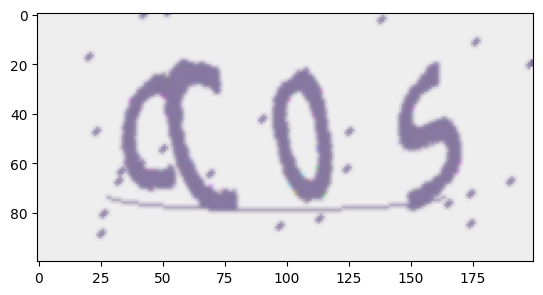

In [ ]:
# 取一张图片查看
img = all_data[0]
plt.imshow(img)


### 图像做归一化

In [ ]:
all_data = all_data/255

In [ ]:
# 划分训练集和验证集
train_data, valid_data, train_labels, valid_labels = train_test_split(all_data, all_labels, test_size=0.2, random_state=7)

print(train_data.shape)
print(train_labels.shape)

(8000, 100, 200, 3)
(8000, 4, 36)


## 设置超参数，制作dataset

In [ ]:
OUTPUT_LEN = 4
BUFFER_SIZE = len(train_data)*2
BATCH_SIZE = 64
EPOCHS = 100

In [ ]:
# 做dataset
train_dataset = tf.data.Dataset.from_tensor_slices((train_data, train_labels)).shuffle(buffer_size=BUFFER_SIZE).batch(BATCH_SIZE)

valid_dataset = tf.data.Dataset.from_tensor_slices((valid_data, valid_labels)).batch(BATCH_SIZE)


## 搭建模型 ResNet50+全连接层

In [ ]:
inputs = keras.Input(shape=(100, 200, 3))
resnet_50 = keras.applications.ResNet50(include_top=False, weights='imagenet', pooling = 'avg')(inputs)

output = keras.layers.Dense(1024, activation='relu')(resnet_50)
output = keras.layers.Dropout(0.2)(output)
output = keras.layers.Dense(512, activation='relu')(output)
output = keras.layers.Dropout(0.2)(output)
outputs = [keras.layers.Dense(36, activation='softmax', name='out%d'%(_+1))(output) for _ in range(OUTPUT_LEN)]
outputs = keras.layers.concatenate(outputs)
outputs = keras.layers.Reshape((OUTPUT_LEN, -1))(outputs)

model = keras.Model(inputs=inputs, outputs=outputs)

model.summary()

94765736/94765736 [==============================] - 0s 0us/step
Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_3 (InputLayer)        [(None, 100, 200, 3)]        0         []                            
                                                                                                  
 resnet50 (Functional)       (None, 2048)                 2358771   ['input_3[0][0]']             
                                                          2                                       
                                                                                                  
 dense_2 (Dense)             (None, 1024)                 2098176   ['resnet50[0][0]']            
                                                                                                  
 dense_3 (Dense)           

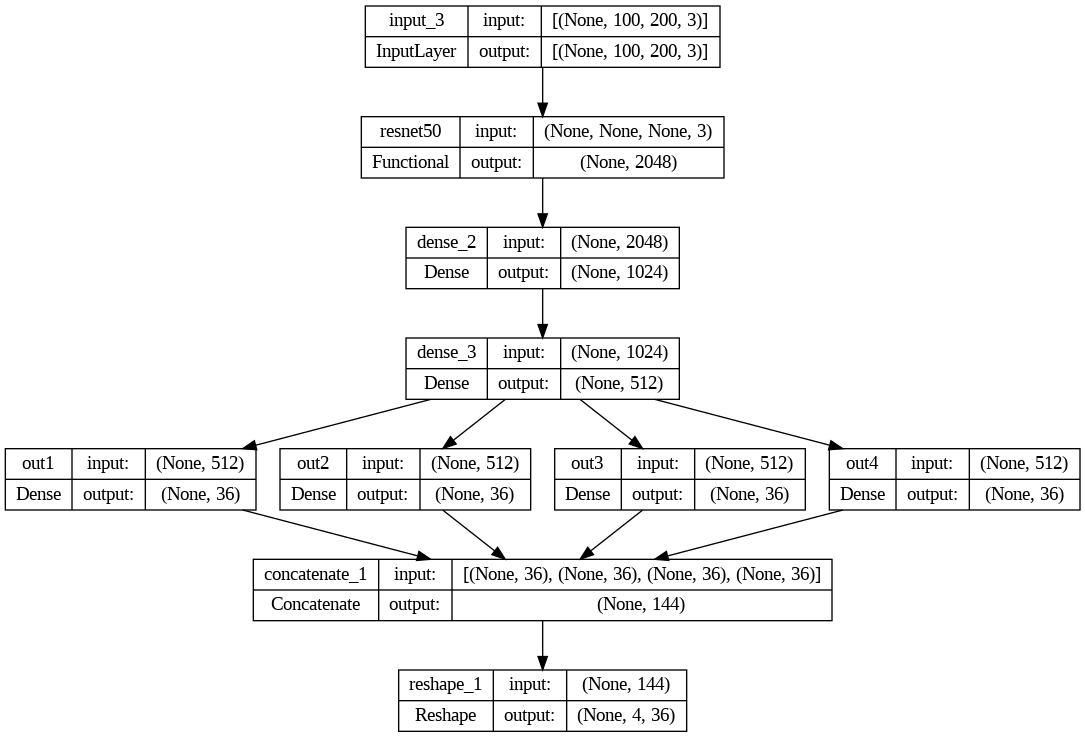

In [ ]:
from keras.utils import plot_model
plot_model(model, to_file='model.png', show_shapes=True)

In [ ]:
model.compile(optimizer=keras.optimizers.Adam(0.001),
              loss='categorical_crossentropy', # one-hot编码时使用
              metrics=['accuracy']
)

# 设置检查点，如果训练过程中断不至于从头训练
checkpoint_dir = 'checkpoints'
if not os.path.exists(checkpoint_dir):
    os.mkdir(checkpoint_dir)

model_name = 'model_2.h5'
output_model_file = os.path.join(checkpoint_dir, model_name)

callbacks = [
    keras.callbacks.EarlyStopping(patience=10, min_delta=1e-4),
    keras.callbacks.ModelCheckpoint(output_model_file, save_best_only=True),
]

In [ ]:
history = model.fit(train_dataset,
                    epochs=EPOCHS,
                    validation_data=valid_dataset,
                    workers=4,
                    use_multiprocessing=True,
                    callbacks=callbacks)

Epoch 1/100
125/125 [==============================] - 52s 148ms/step - loss: 3.1741 - accuracy: 0.1213 - val_loss: 3.9292 - val_accuracy: 0.0301
Epoch 2/100
125/125 [==============================] - 14s 115ms/step - loss: 1.3856 - accuracy: 0.5634 - val_loss: 4.5322 - val_accuracy: 0.0284
Epoch 3/100
125/125 [==============================] - 14s 115ms/step - loss: 0.4126 - accuracy: 0.8704 - val_loss: 4.4380 - val_accuracy: 0.0292
Epoch 4/100
125/125 [==============================] - 14s 115ms/step - loss: 0.1953 - accuracy: 0.9377 - val_loss: 5.1266 - val_accuracy: 0.0289
Epoch 5/100
125/125 [==============================] - 14s 115ms/step - loss: 0.1446 - accuracy: 0.9523 - val_loss: 4.0206 - val_accuracy: 0.1933
Epoch 6/100
125/125 [==============================] - 18s 144ms/step - loss: 0.1338 - accuracy: 0.9561 - val_loss: 3.1136 - val_accuracy: 0.3923
Epoch 7/100
125/125 [==============================] - 16s 126ms/step - loss: 0.1189 - accuracy: 0.9620 - val_loss: 0.5268 -

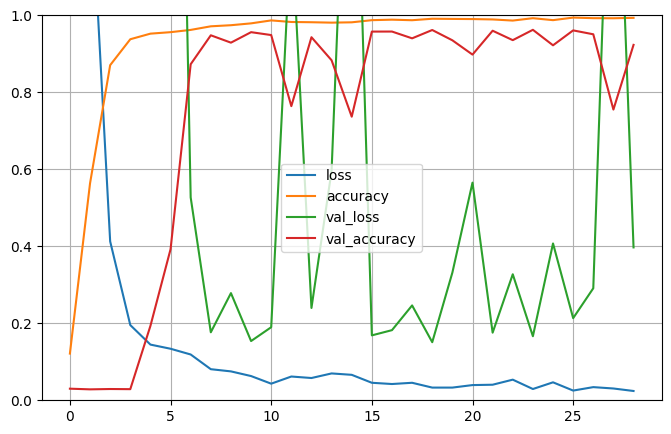

In [ ]:
import pandas as pd
# learning curves
def plot_learning_curves(history):
    pd.DataFrame(history.history).plot(figsize=(8, 5))
    plt.grid(True)
    plt.gca().set_ylim(0, 1)
    plt.show()

plot_learning_curves(history)

In [ ]:
# 加载模型权重
model.load_weights(output_model_file)

In [ ]:
# 验证集上的准确率
acc = model.evaluate(valid_dataset)
print(acc)

32/32 [==============================] - 1s 40ms/step - loss: 0.1508 - accuracy: 0.9617
[0.15084587037563324, 0.9617499709129333]


In [ ]:
!pip install captcha

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 102.2/102.2 kB 3.2 MB/s eta 0:00:00


In [ ]:
# 生成20张图片并预测
from captcha.image import ImageCaptcha
import random
import os

width = 200
height = 100

generator = ImageCaptcha(width=width, height=height)
if not os.path.exists('images'):
    os.makedirs('images')
for i in range(20):
    random_str = ''.join([random.choice(characters) for _ in range(4)])
    img = generator.generate_image(random_str)

    pred = model.predict(np.array([np.array(img)/255]))
    print('true:', random_str, end=' ')
    print('pred:', ''.join([characters[np.argmax(_) ] for _ in pred[0]]))
    print('------------------')

1/1 [==============================] - 1s 1s/step
true: VNBI pred: VNBI
------------------
1/1 [==============================] - 0s 22ms/step
true: 7G7Y pred: 7G7Y
------------------
1/1 [==============================] - 0s 21ms/step
true: DMSR pred: DMSR
------------------
1/1 [==============================] - 0s 22ms/step
true: 4W1W pred: 4W1W
------------------
1/1 [==============================] - 0s 24ms/step
true: H2V3 pred: H2V3
------------------
1/1 [==============================] - 0s 21ms/step
true: 39G3 pred: 39G3
------------------
1/1 [==============================] - 0s 20ms/step
true: 9F04 pred: 9FO4
------------------
1/1 [==============================] - 0s 23ms/step
true: RZO8 pred: RZ08
------------------
1/1 [==============================] - 0s 21ms/step
true: A3ZH pred: A3ZH
------------------
1/1 [==============================] - 0s 22ms/step
true: 6BCW pred: 6BCW
------------------
1/1 [==============================] - 0s 21ms/step
true: 3QWW pred: 3QW

In [ ]:
# 生成1000张图片并预测
from captcha.image import ImageCaptcha
from tqdm import tqdm
import random
import os

width = 200
height = 100
test_num = 1000
generator = ImageCaptcha(width=width, height=height)

count = 0
for i in tqdm(range(test_num)):
    random_str = ''.join([random.choice(characters) for _ in range(4)])
    img = generator.generate_image(random_str)

    pred = model.predict(np.array([np.array(img)/255]), verbose=0)
    true_str = ''.join([characters[np.argmax(_) ] for _ in pred[0]])

    if true_str == random_str:
      count += 1

print(count)
print('acc: %f'%(count/test_num))

100%|██████████| 1000/1000 [00:57<00:00, 17.31it/s]

866
acc: 0.866000
